### Makemore but with MLP

based on this paper: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

In [2]:
words = open("assamese.txt", "r").read().split()
words = [
    w
    for w in words
    if "১"
    and "২"
    and "৩"
    and "৪"
    and "৫"
    and "৬"
    and "৭"
    and "৮"
    and "৯"
    and "০" not in w
]

In [5]:
max(words)

'’হিছট’ৰি'

In [6]:
characters = sorted(list((set("".join(words)))))
stoi = {s: i + 1 for i, s in enumerate(characters)}
stoi["~"] = 0
itos = {i: s for s, i in stoi.items()}
print(characters)

['%', "'", ',', '-', '.', '/', ':', ';', '?', 'A', 'F', 'I', 'P', 'U', '°', '।', '॰', 'ঁ', 'ং', 'ঃ', 'অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ', 'ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'য', 'ল', 'শ', 'ষ', 'স', 'হ', '়', 'া', 'ি', 'ী', 'ু', 'ূ', 'ৃ', 'ে', 'ৈ', 'ো', 'ৌ', '্', 'ৎ', '১', '২', '৩', '৪', '৫', '৬', '৭', '৮', '৯', 'ৰ', 'ৱ', '৷', '\u200c', '\u200d', '—', '‘', '’']


In [7]:
vocab = len(characters) + 1

In [6]:
# building the dataset

block_size = 3  # context length: how many characters do we need to predict the next one
X, Y = [], []
for w in words[:2]:
    print(w)
    context = [0] * block_size
    for ch in w + "~":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print("".join(itos[i] for i in context), "-->", itos[ix])
        context = context[1:] + [ix]  # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

মলিনা
~~~ --> ম
~~ম --> ল
~মল --> ি
মলি --> ন
লিন --> া
িনা --> ~
দেৱী
~~~ --> দ
~~দ --> ে
~দে --> ৱ
দেৱ --> ী
েৱী --> ~


In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([11, 3]), torch.int64, torch.Size([11]), torch.int64)

In [8]:
C = torch.randn((vocab, 2))

In [9]:
F.one_hot(torch.tensor(5), num_classes=vocab).float() @ C

tensor([0.8572, 0.3165], device='cuda:0')

### The Neural Net 🥁

In [10]:
# building the dataset

block_size = 3  # context length: how many characters do we need to predict the next one
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]  # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)


In [11]:
X.shape

torch.Size([165189, 3])

Final Loss = 11.035784721374512


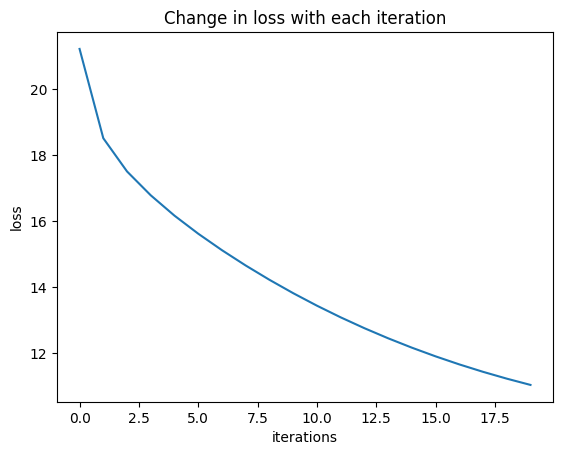

In [12]:
C = torch.randn((vocab, 2))
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W2 = torch.randn((100, vocab))
b2 = torch.randn(vocab)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

losses = []
iters = 20
for _ in range(iters):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    losses.append(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad


plt.plot(range(iters), losses)
plt.title("Change in loss with each iteration")
plt.ylabel("loss")
plt.xlabel("iterations")
print(f"Final Loss = {losses.pop()}")

this took up way too much time. so let's do this in batches, or rather ✨*mini-batches*✨

In [13]:
torch.randint(0, X.size(0), (32,))

tensor([128004,  58588, 106802, 100734, 101469,   4898, 161770, 141141,  33882,
         46636,  55256,   8193,  27004, 141879,   4851, 162924,   3176,  24707,
         70749, 148460,  63876,  88869, 113746,  29732, 103085, 111813,  71046,
        121153,  44557,  27173, 108861,  24999], device='cuda:0')

In [14]:
C = torch.randn((vocab, 2))
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W2 = torch.randn((100, vocab))
b2 = torch.randn(vocab)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True


In [15]:
iters = 10000
losses = []
for _ in range(iters):
    # mini batch
    ix = torch.randint(0, X.size(0), (200,))
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # losses.append(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.013 * p.grad


# plt.plot(range(iters), losses)
# plt.title("Change in loss with each iteration (for the mini-batch)")
# plt.ylabel("loss")
# plt.xlabel("iterations")
# print(f"Final Loss = {losses.pop()}")


In [16]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss.item()

2.966559410095215

#### Well, but how do you find the optimal learning rate?

We experiment a bit to find out the range in which the rate is not cringe. Then we start from the big number of that range and slide into the lower bound with each iteration. We then finally choose the learning rate that gives the best result.

![](https://media.tenor.com/A6yz-HeOGIgAAAAM/leonardo-dicaprio-leonardo-dicaprio-meme.gif)

### Learning rate decay

We often lower the learning rate in the later stages of learning. This is called learning rate decay.

In [17]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [18]:
C = torch.randn((vocab, 2))
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W2 = torch.randn((100, vocab))
b2 = torch.randn(vocab)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True


Final Loss = 3.246950626373291


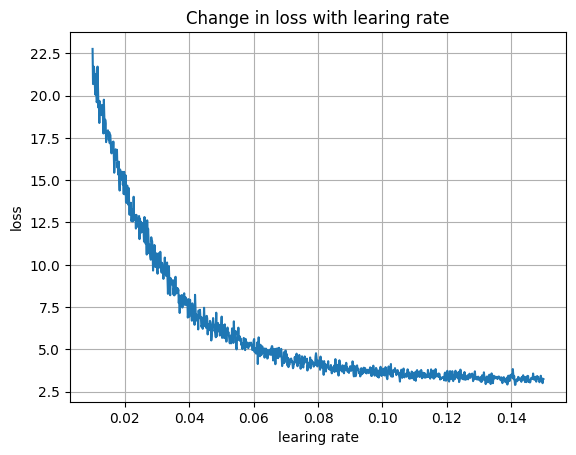

In [19]:
iters = 1000
losses = []
lrs = torch.linspace(0.01, 0.15, 1000)
for i in range(iters):
    # mini batch
    ix = torch.randint(0, X.size(0), (200,))
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    losses.append(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -lrs[i] * p.grad


plt.plot(lrs.tolist(), losses)
plt.title("Change in loss with learing rate")
plt.ylabel("loss")
plt.xlabel("learing rate")
plt.grid()
print(f"Final Loss = {losses.pop()}")


How many parameters do we have?

In [20]:
sum(p.nelement() for p in parameters)

10279

### Let's get real

It shoud come at no surprise that this not how we do shit in prod. Irl, we have several splits/phases for preparing our neural net for the real world.

| ➡️ | training split | dev/validation split | test split |
|--------|----------------|----------------------|------------|
| shares | 80%            | 10%                  | 10%        |


In [21]:
import random


def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + "~":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"{X.shape=}, {Y.shape=}")
    return X, Y


random.seed(2002)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

X.shape=torch.Size([131912, 3]), Y.shape=torch.Size([131912])
X.shape=torch.Size([16617, 3]), Y.shape=torch.Size([16617])
X.shape=torch.Size([16660, 3]), Y.shape=torch.Size([16660])


In [22]:
C = torch.randn((vocab, 2))
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W2 = torch.randn((100, vocab))
b2 = torch.randn(vocab)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True


In [23]:
loss = None
for i in range(40000):
    # mini batch
    ix = torch.randint(0, Xtr.size(0), (200,))
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad

In [24]:
print(loss.item())

2.4125096797943115


We evaluate the performance of the neural net on our dev split. Keep in mind that these are the data that the neural net has not seen and is not trained on.

In [25]:
# Evaluating the loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.4804108142852783

Let's check what is the loss for the training set itself.

In [26]:
# Evaluating the loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.4857709407806396

The training set and dev set losses are not equal. This means the model is not overfitted. That implies the model is not 'memorizing' the training data.

But, since the training and dev dataset losses are roughly equal, this means that the model is underfitted. This is a good hint that our network is very tiny and we need to expand our network.


In [27]:
C = torch.randn((vocab, 2))
W1 = torch.randn((6, 300))
b1 = torch.randn(300)
W2 = torch.randn((300, vocab))
b2 = torch.randn(vocab)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

30279

In [28]:
steps = []
losses = []

for i in range(40000):
    # mini batch
    ix = torch.randint(0, Xtr.size(0), (32,))
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.01 * p.grad
    steps.append(i)
    losses.append(loss.item())


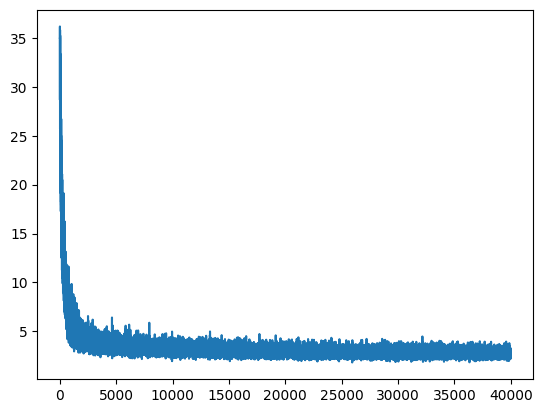

In [29]:
plt.plot(steps, losses)

In [30]:
# Evaluating the loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.7393715381622314

In [31]:
# Evaluating the loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.7596161365509033

Visualizing the embeddings

/mnt/d/PROJECTS/Neural_Network/env/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 2404 (\N{DEVANAGARI DANDA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/mnt/d/PROJECTS/Neural_Network/env/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Matplotlib currently does not support Devanagari natively.
  func(*args, **kwargs)
/mnt/d/PROJECTS/Neural_Network/env/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 2416 (\N{DEVANAGARI ABBREVIATION SIGN}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/mnt/d/PROJECTS/Neural_Network/env/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 2433 (\N{BENGALI SIGN CANDRABINDU}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/mnt/d/PROJECTS/Neural_Network/env/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Matplotlib currently does not support Bengali natively.
  func(*args, **kwargs)
/mnt/d/PROJECTS/Neura

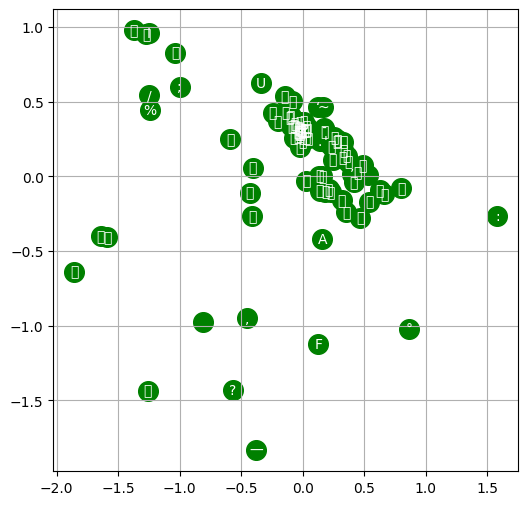

In [32]:
plt.figure(figsize=(6, 6))
plt.scatter(C[:, 0].data.tolist(), C[:, 1].data.tolist(), s=200, color="green")
for i in range(C.size(0)):
    plt.text(
        C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white"
    )
plt.grid("minor")

Now that we observe we can't go much beyond our previous simple neural net, and we have already played with the weights, biases and tried expanding the number of neurons, we are begininning to suspect that the dimension of the embedding vector might be the bottleneck.

So, next we try changing that.

In [33]:
C = torch.randn((vocab, 20))
W1 = torch.randn((60, 300)) * 0.1
b1 = torch.randn(300) * 0.01
W2 = torch.randn((300, vocab)) * 0.1
b2 = torch.randn(vocab) * 0
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

48153

In [34]:
steps = []
losses = []

In [35]:
max_steps = 50000
for i in range(max_steps):
    # mini batch
    ix = torch.randint(0, Xtr.size(0), (32,))
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 60) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.01 * p.grad
    steps.append(i)
    losses.append(loss.log10().item())
    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

      0/  50000: 4.9164
  10000/  50000: 1.8134
  20000/  50000: 2.3164
  30000/  50000: 1.8066
  40000/  50000: 1.6254


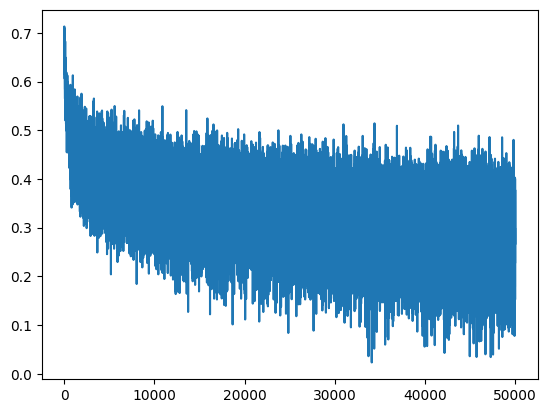

In [36]:
plt.plot(steps, losses)

In [37]:
# Evaluating the loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 60) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

1.9742869138717651

In [38]:
# Evaluating the loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 60) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.item()

1.9550048112869263

In [39]:
# sample from the model
for _ in range(10):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

আতা-বিছিল~
অভিনয়~
মন্পক্ষিণ~
বৰে~
সংগীৰ~
আছেলা,~
হৈ~
বোম্খযৰ~
শাকৰ~
অভি‘য়~


In [40]:
# sample from the model
# g = torch.Generator().manual_seed(2002)
for _ in range(10):
    out = []
    context = [stoi[i] for i in "মোৰ"]  # initialize with all ...
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out), end=" ")


~ াজ্টামগত~ াহুছেলাভ~ ীজল~ ে~ তা~ ালাৰ~ ি~ ্লীয়~ াজাদাশ~ 